In [64]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [65]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from prophet import Prophet


In [80]:
file_path = '/Users/sohnikareddy/Desktop/capstone project/data/final_cleaned_lead_time_data.csv'
data = pd.read_csv(file_path)

In [81]:
data['Order DateTime'] = pd.to_datetime(data['Order DateTime'])


/var/folders/s8/jl_2h7g16pv9cc4rq7nxxxgm0000gn/T/ipykernel_88986/1204371738.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Order DateTime'] = pd.to_datetime(data['Order DateTime'])


In [82]:
monthly_orders = data.groupby(data['Order DateTime'].dt.to_period('M'))['Order Quantity'].sum()
monthly_orders = monthly_orders.to_timestamp()


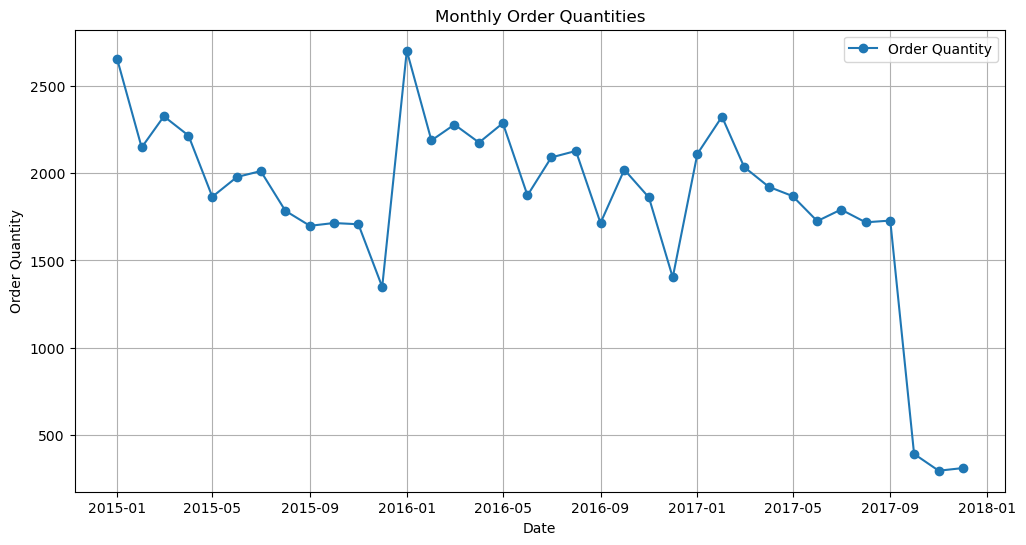

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_orders, marker='o', label='Order Quantity')
plt.title('Monthly Order Quantities')
plt.xlabel('Date')
plt.ylabel('Order Quantity')
plt.legend()
plt.grid()
plt.show()

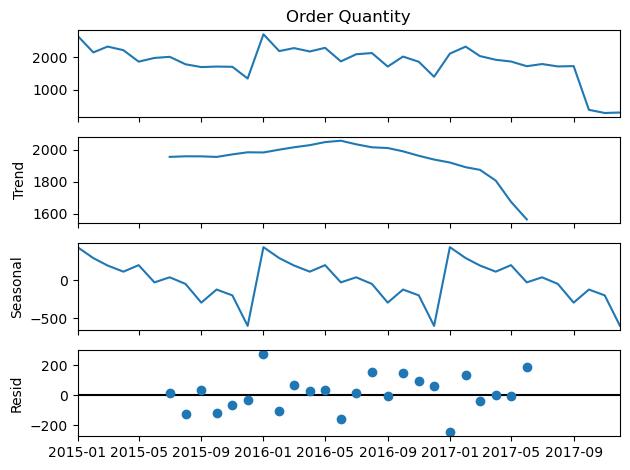

In [83]:
decompose_result = seasonal_decompose(monthly_orders, model='additive', period=12)
decompose_result.plot()
plt.show()

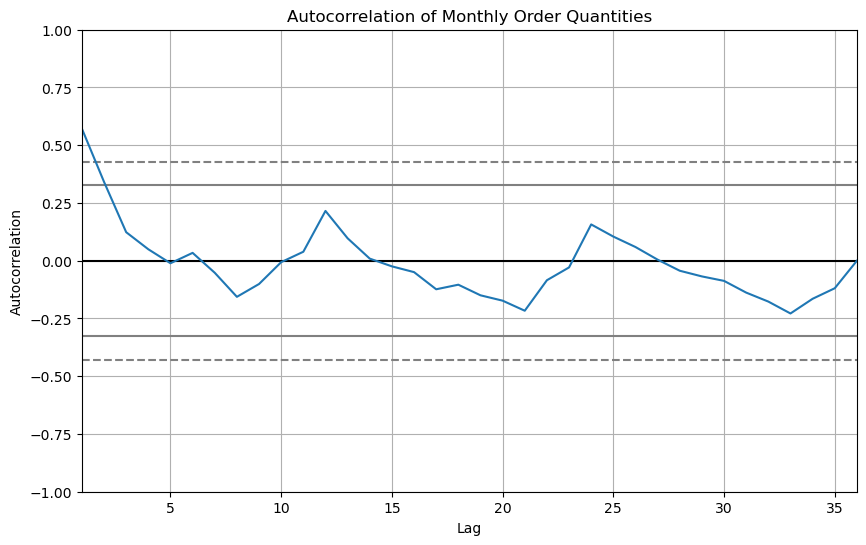

In [84]:
plt.figure(figsize=(10, 6))
autocorrelation_plot(monthly_orders)
plt.title('Autocorrelation of Monthly Order Quantities')
plt.show()

In [85]:
data['Order Date'] = pd.to_datetime(data['Order Date'])

/var/folders/s8/jl_2h7g16pv9cc4rq7nxxxgm0000gn/T/ipykernel_88986/3021409918.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Order Date'] = pd.to_datetime(data['Order Date'])


In [159]:
weekly_data = data.groupby(pd.Grouper(key='Order Date', freq='W'))['Order Quantity'].sum().reset_index()
weekly_data.rename(columns={'Order Date': 'Week', 'Order Quantity': 'Total Quantity'}, inplace=True)

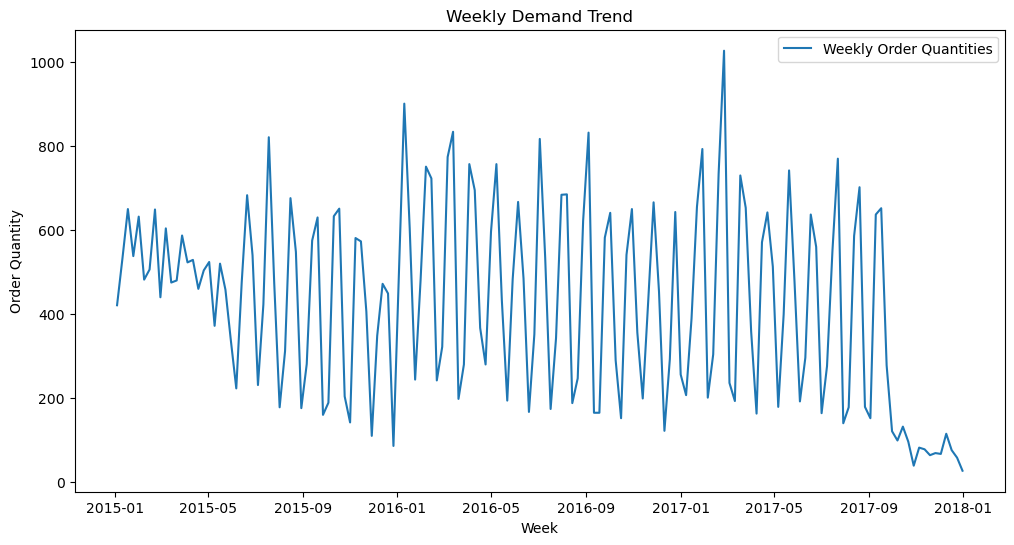

In [160]:
plt.figure(figsize=(12, 6))
plt.plot(weekly_data['Week'], weekly_data['Total Quantity'], label='Weekly Order Quantities')
plt.title('Weekly Demand Trend')
plt.xlabel('Week')
plt.ylabel('Order Quantity')
plt.legend()
plt.show()

In [88]:
train_size = int(len(weekly_data) * 0.8)
train, test = weekly_data[:train_size], weekly_data[train_size:]


In [89]:
arima_model = ARIMA(train['Total Quantity'], order=(5, 1, 0))
arima_fitted = arima_model.fit()

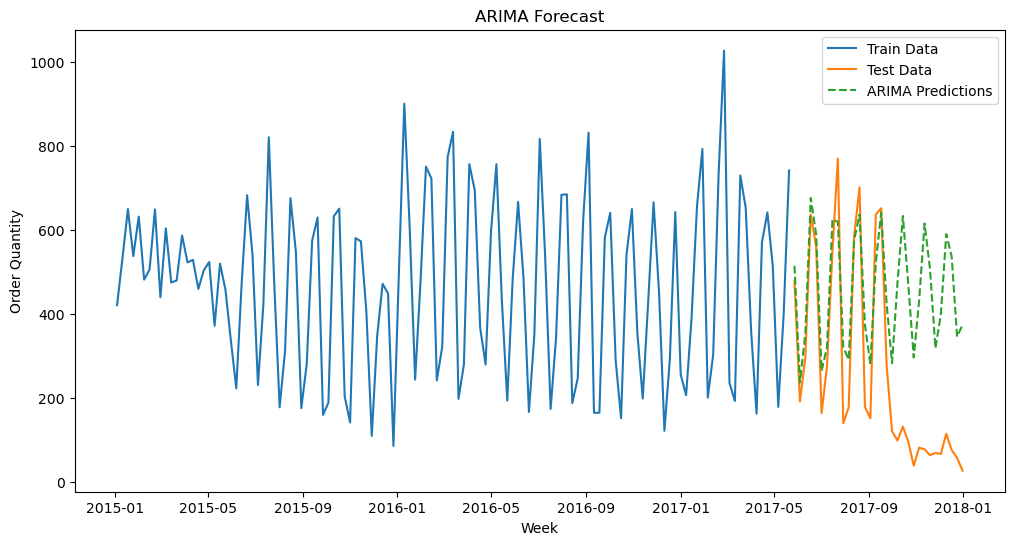

In [91]:
arima_forecast = arima_fitted.forecast(steps=len(test))
plt.figure(figsize=(12, 6))
plt.plot(train['Week'], train['Total Quantity'], label='Train Data')
plt.plot(test['Week'], test['Total Quantity'], label='Test Data')
plt.plot(test['Week'], arima_forecast, label='ARIMA Predictions', linestyle='--')
plt.title('ARIMA Forecast')
plt.xlabel('Week')
plt.ylabel('Order Quantity')
plt.legend()
plt.show()


In [92]:
prophet_data = weekly_data.rename(columns={'Week': 'ds', 'Total Quantity': 'y'})
prophet_train = prophet_data[:train_size]
prophet_test = prophet_data[train_size:]

prophet_model = Prophet()
prophet_model.fit(prophet_train)
future = prophet_model.make_future_dataframe(periods=len(prophet_test), freq='W')
forecast = prophet_model.predict(future)


20:44:26 - cmdstanpy - INFO - Chain [1] start processing
20:44:26 - cmdstanpy - INFO - Chain [1] done processing


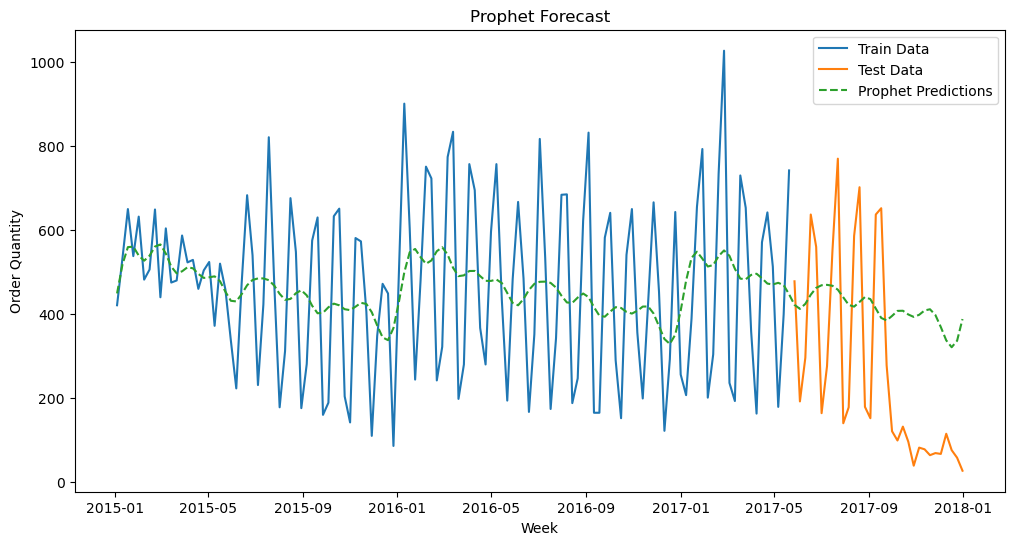

In [93]:
plt.figure(figsize=(12, 6))
plt.plot(train['Week'], train['Total Quantity'], label='Train Data')
plt.plot(test['Week'], test['Total Quantity'], label='Test Data')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Predictions', linestyle='--')
plt.title('Prophet Forecast')
plt.xlabel('Week')
plt.ylabel('Order Quantity')
plt.legend()
plt.show()

In [163]:
prophet_predictions = forecast['yhat'].iloc[-len(prophet_test):].values
actual_values = prophet_test['y'].values
rmse = np.sqrt(mean_squared_error(actual_values, prophet_predictions))
print(f"Prophet RMSE: {rmse}")

Prophet RMSE: 223.31259180334976


In [94]:
weekly_data['Week_Number'] = np.arange(len(weekly_data))
X = weekly_data[['Week_Number']]
y = weekly_data['Total Quantity']

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

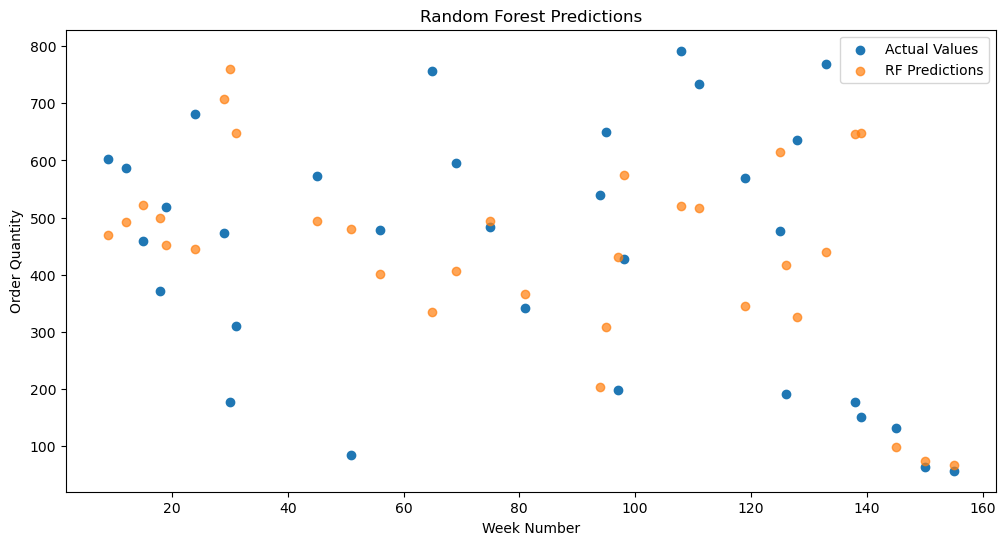

In [164]:
plt.figure(figsize=(12, 6))
plt.scatter(X_test, y_test, label='Actual Values')
plt.scatter(X_test, rf_predictions, label='RF Predictions', alpha=0.7)
plt.title('Random Forest Predictions')
plt.xlabel('Week Number')
plt.ylabel('Order Quantity')
plt.legend()
plt.show()


In [98]:
arima_rmse = np.sqrt(mean_squared_error(test['Total Quantity'], arima_forecast))
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))

print(f"ARIMA RMSE: {arima_rmse}")
print(f"Random Forest RMSE: {rf_rmse}")

ARIMA RMSE: 264.35610774707754
Random Forest RMSE: 263.19456936005537


In [99]:
correlation = data[['Discount %', 'Order Quantity']].corr()
print("Correlation Matrix:\n", correlation)

Correlation Matrix:
                 Discount %  Order Quantity
Discount %        1.000000       -0.004399
Order Quantity   -0.004399        1.000000


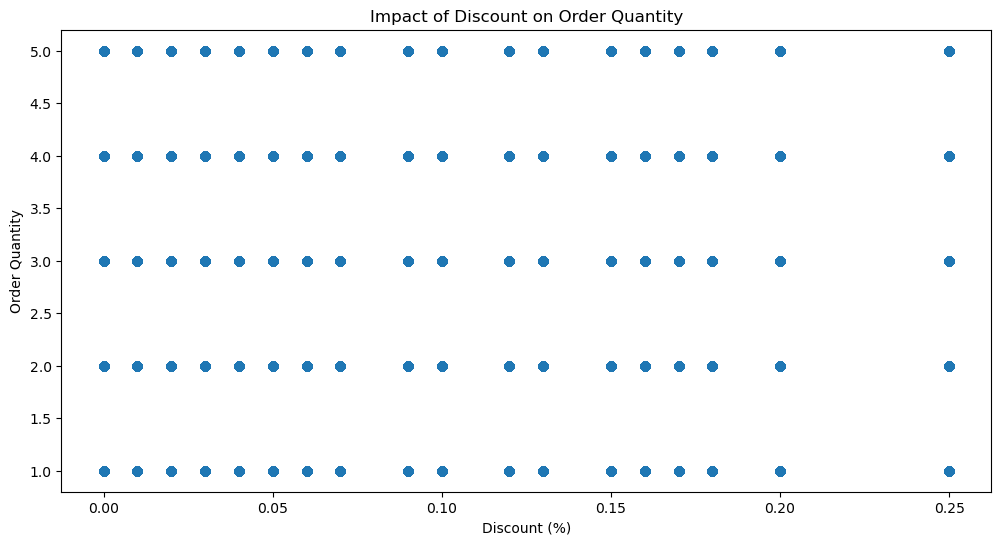

In [100]:
plt.figure(figsize=(12, 6))
plt.scatter(data['Discount %'], data['Order Quantity'], alpha=0.5)
plt.title('Impact of Discount on Order Quantity')
plt.xlabel('Discount (%)')
plt.ylabel('Order Quantity')
plt.show()


In [103]:
discount_levels = [0.1, 0.2, 0.3]  
simulated_demand = {}

In [104]:
for discount in discount_levels:
    data['Simulated Order Quantity'] = data['Order Quantity'] * (1 + (discount - data['Discount %']))
    simulated_demand[f"{int(discount * 100)}% Discount"] = data['Simulated Order Quantity'].sum()

print("Simulated Demand by Discount Levels:", simulated_demand)

Simulated Demand by Discount Levels: {'10% Discount': 66294.95999999999, '20% Discount': 72931.66, '30% Discount': 79568.36}


Demand by Shipment Mode:
 Shipment Mode
First Class       10262
Same Day           4317
Second Class      13023
Standard Class    38765
Name: Order Quantity, dtype: int64


<Axes: title={'center': 'Demand by Shipment Mode'}, xlabel='Shipment Mode', ylabel='Order Quantity'>

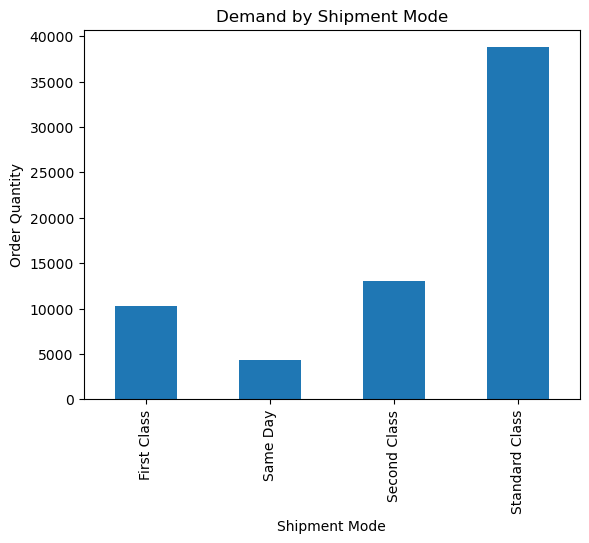

In [165]:
shipment_demand = data.groupby('Shipment Mode')['Order Quantity'].sum()
print("Demand by Shipment Mode:\n", shipment_demand)

shipment_demand.plot(kind='bar', title='Demand by Shipment Mode', ylabel='Order Quantity', xlabel='Shipment Mode')

Simulated Regional Demand:
 Customer Region
Canada               418
Caribbean           2971
Central Africa       564
Central America    11331
Central Asia         245
East Africa          591
East of USA         2705
Eastern Asia        2265
Eastern Europe      1529
North Africa        1143
Northern Europe     3576
Oceania             2926
South America       5840
South Asia          2568
South of  USA       1592
Southeast Asia      3282
Southern Africa      581
Southern Europe     3212
US Center           2530
West Africa         1550
West Asia           2402
West of USA         2907
Western Europe      9639
Name: Simulated Regional Demand, dtype: int64


<Axes: title={'center': 'Simulated Regional Demand'}, xlabel='Customer Region', ylabel='Order Quantity'>

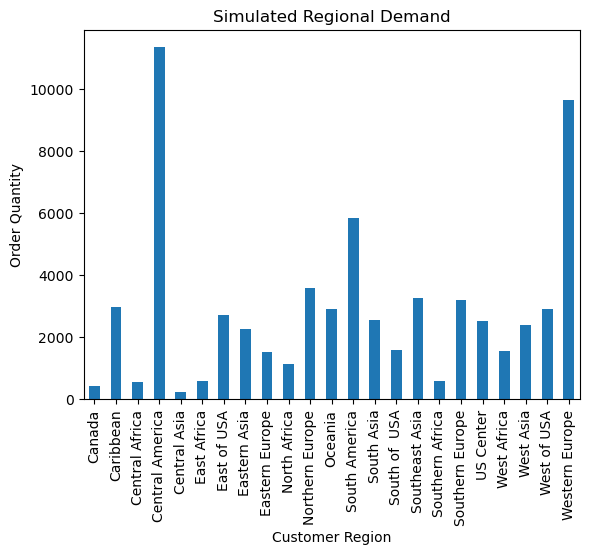

In [45]:
region_growth_rates = {'Europe': 0.1, 'LATAM': 0.2}  # 10% growth in Europe, 20% in LATAM
data['Simulated Regional Demand'] = data.apply(
    lambda row: row['Order Quantity'] * (1 + region_growth_rates.get(row['Customer Region'], 0)), axis=1
)

regional_demand = data.groupby('Customer Region')['Simulated Regional Demand'].sum()
print("Simulated Regional Demand:\n", regional_demand)

regional_demand.plot(kind='bar', title='Simulated Regional Demand', ylabel='Order Quantity', xlabel='Customer Region')


In [48]:
segment_analysis = data.groupby(['Customer Region', 'Product Category'])['Order Quantity'].sum().unstack()
print("Segment Analysis:\n", segment_analysis)

Segment Analysis:
 Product Category  Accessories  As Seen on  TV!  Baby  Baseball & Softball  \
Customer Region                                                             
Canada                    4.0              NaN   NaN                  NaN   
Caribbean                44.0              NaN   NaN                 14.0   
Central Africa            9.0              NaN   NaN                  1.0   
Central America         109.0              5.0   NaN                 37.0   
Central Asia              7.0              NaN   NaN                  NaN   
East Africa               6.0              NaN   NaN                  NaN   
East of USA              40.0              NaN   NaN                 31.0   
Eastern Asia             26.0              NaN   NaN                  5.0   
Eastern Europe           40.0              NaN   NaN                  4.0   
North Africa             31.0              NaN   NaN                 19.0   
Northern Europe          31.0              4.0  10.0     

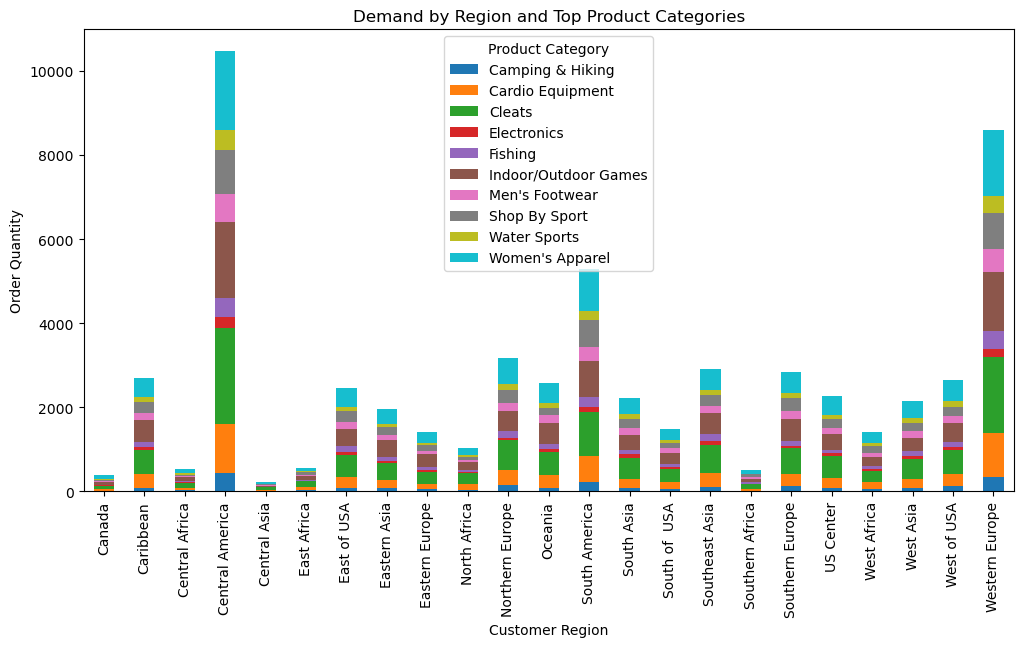

In [51]:
top_categories = data.groupby('Product Category')['Order Quantity'].sum().nlargest(10).index
filtered_data = data[data['Product Category'].isin(top_categories)]
segment_analysis = filtered_data.groupby(['Customer Region', 'Product Category'])['Order Quantity'].sum().unstack()
segment_analysis.plot(kind='bar', stacked=True, figsize=(12, 6), title='Demand by Region and Top Product Categories')
plt.ylabel('Order Quantity')
plt.xlabel('Customer Region')
plt.legend(title='Product Category')
plt.show()

In [118]:
from statsmodels.tsa.arima.model import ARIMA

In [119]:
arima_model = ARIMA(train['Total Quantity'], order=(5, 1, 0))  # Adjust (p, d, q) as needed
arima_fitted_auto = arima_model.fit()

In [107]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [108]:
def simulate_scenario(test_data, scenario_type="spike", percentage=50, start_idx=10, end_idx=14):
    modified_test = test_data.copy()
    if scenario_type == "spike":
        modified_test.loc[start_idx:end_idx, 'Total Quantity'] *= (1 + percentage / 100)
    elif scenario_type == "drop":
        modified_test.loc[start_idx:end_idx, 'Total Quantity'] *= (1 - percentage / 100)
    return modified_test

In [109]:
def forecast_arima(model, test_length):
    return model.predict(n_periods=test_length)


In [110]:
def forecast_prophet(prophet_model, test_length, train_data):
    future = prophet_model.make_future_dataframe(periods=test_length, freq='W')
    forecast = prophet_model.predict(future)
    return forecast[-test_length:]['yhat']

In [111]:
def forecast_rf(rf_model, test_features):
    return rf_model.predict(test_features)

In [112]:
def calculate_metrics(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted)
    return {"RMSE": rmse, "MAPE (%)": mape}

In [166]:
def visualize_results(actual, arima_pred, prophet_pred, rf_pred, test_weeks):
    plt.figure(figsize=(12, 6))
    plt.plot(test_weeks, actual, label='Scenario Demand', marker='o')
    plt.plot(test_weeks, arima_pred, label='ARIMA Forecast', linestyle='--')
    plt.plot(test_weeks, prophet_pred, label='Prophet Forecast', linestyle='--')
    plt.plot(test_weeks, rf_pred, label='Random Forest Forecast', linestyle='--')
    plt.title('Scenario Testing Results')
    plt.xlabel('Week')
    plt.ylabel('Total Quantity')
    plt.legend()
    plt.grid()
    plt.show()

In [115]:
scenario_test = simulate_scenario(test, scenario_type="spike", percentage=50, start_idx=10, end_idx=14)

In [120]:
arima_pred = forecast_arima(arima_fitted_auto, len(scenario_test))

In [122]:
if 'Week_Number' not in scenario_test.columns:
    scenario_test['Week_Number'] = np.arange(len(scenario_test))

In [123]:
print(scenario_test.columns)

Index(['Week', 'Total Quantity', 'Week_Number'], dtype='object')


In [124]:
rf_pred = forecast_rf(rf_model, scenario_test[['Week_Number']])

In [127]:
print("Scenario Test Weeks:", len(scenario_test['Week']))
print("ARIMA Predictions:", len(arima_pred))
print("Prophet Predictions:", len(prophet_pred))
print("Random Forest Predictions:", len(rf_pred))

Scenario Test Weeks: 32
ARIMA Predictions: 125
Prophet Predictions: 32
Random Forest Predictions: 32


In [128]:
arima_pred = arima_pred[:len(scenario_test)]

In [129]:
prophet_pred = prophet_pred[:len(scenario_test)]

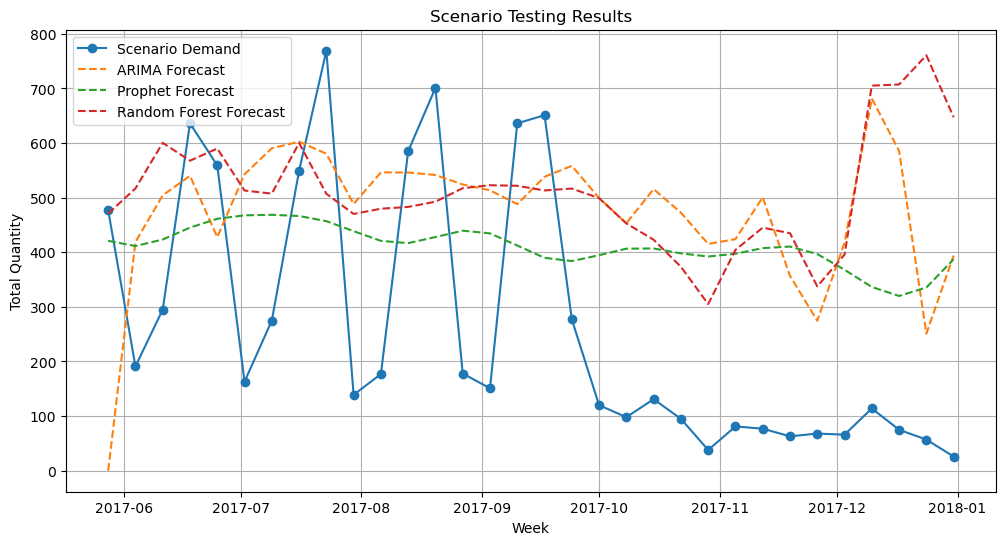

In [130]:
visualize_results(
    actual=scenario_test['Total Quantity'],
    arima_pred=arima_pred,
    prophet_pred=prophet_pred,
    rf_pred=rf_pred,
    test_weeks=scenario_test['Week']
)

In [132]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [133]:
arima_rmse = np.sqrt(mean_squared_error(scenario_test['Total Quantity'], arima_pred))
arima_mape = mean_absolute_percentage_error(scenario_test['Total Quantity'], arima_pred)


In [134]:
prophet_rmse = np.sqrt(mean_squared_error(scenario_test['Total Quantity'], prophet_pred))
prophet_mape = mean_absolute_percentage_error(scenario_test['Total Quantity'], prophet_pred)

In [135]:
rf_rmse = np.sqrt(mean_squared_error(scenario_test['Total Quantity'], rf_pred))
rf_mape = mean_absolute_percentage_error(scenario_test['Total Quantity'], rf_pred)


In [179]:
model_performance = pd.DataFrame({
    "Model": ["ARIMA", "Prophet", "Random Forest"],
    "RMSE": [arima_rmse, prophet_rmse, rf_rmse],
})

print(model_performance)

           Model        RMSE
0          ARIMA  320.653871
1        Prophet  261.602640
2  Random Forest  342.056797


Stockout Risk Minimization Using Prophet

In [167]:
file_path = '/Users/sohnikareddy/Desktop/capstone project/data/final_cleaned_lead_time_data.csv'
data = pd.read_csv(file_path)

In [168]:
shipment_data['Order Date'] = pd.to_datetime(shipment_data['Order Date'])
weekly_demand = shipment_data.groupby(pd.Grouper(key='Order Date', freq='W'))['Order Quantity'].sum().reset_index()
weekly_demand.rename(columns={'Order Date': 'ds', 'Order Quantity': 'y'}, inplace=True)

In [169]:
prophet_model = Prophet()
prophet_model.fit(weekly_demand)

09:27:21 - cmdstanpy - INFO - Chain [1] start processing
09:27:21 - cmdstanpy - INFO - Chain [1] done processing


In [170]:
future = prophet_model.make_future_dataframe(periods=7, freq='D')  # Forecast for 7 days (example)
forecast = prophet_model.predict(future)

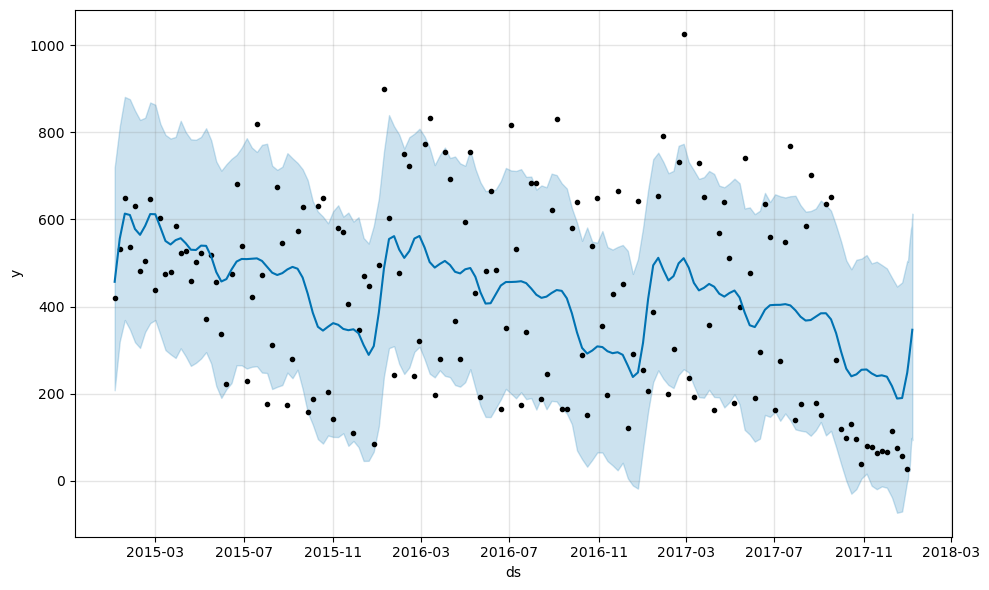

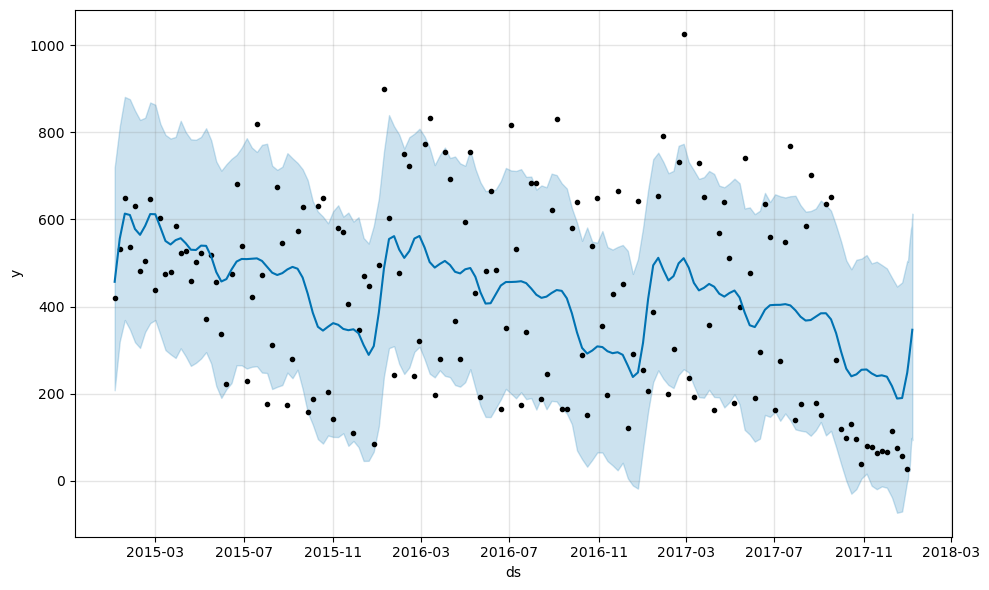

In [171]:
prophet_model.plot(forecast)

In [172]:
import numpy as np
from scipy.stats import norm

In [173]:
file_path = '/Users/sohnikareddy/Desktop/capstone project/data/final_cleaned_lead_time_data.csv'
data = pd.read_csv(file_path)

In [174]:
lead_time = shipment_data['Lead Time (Days)'].mean()  # Average lead time
service_level = 0.95  # Desired service level
demand_std = weekly_demand['y'].std()  # Standard deviation of weekly demand
daily_demand = weekly_demand['y'].mean() / 7  # Average daily demand

In [186]:
print('daily demand is',daily_demand)
print('Average lead time is',lead_time)
print('standard deviation of weekly demand is',demand_std)

daily demand is 60.388535031847134
Average lead time is 21.207541057950827
standard deviation of weekly demand is 228.46471517935973


In [175]:
z_score = norm.ppf(service_level)

In [185]:
print('z score is',z_score)

z score is 1.6448536269514722


In [177]:
safety_stock = z_score * np.sqrt(lead_time) * demand_std
print(f"Safety Stock: {safety_stock}")

Safety Stock: 1730.5794837331027


In [178]:
reorder_point = (daily_demand * lead_time) + safety_stock
print(f"Reorder Point: {reorder_point}")

Reorder Point: 3011.2718198505027


In [1]:
!pip install pandas statsmodels

In [2]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

In [3]:
dataset_path = "final_cleaned_lead_time_data.csv"
data = pd.read_csv(dataset_path)

# Convert Order Date to datetime format
data["Order Date"] = pd.to_datetime(data["Order Date"], errors="coerce")

/var/folders/s8/jl_2h7g16pv9cc4rq7nxxxgm0000gn/T/ipykernel_40938/1124882209.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Order Date"] = pd.to_datetime(data["Order Date"], errors="coerce")


In [4]:
# Aggregate total order quantity by month for forecasting
monthly_demand = (
    data.groupby([data["Order Date"].dt.to_period("M"), "Product Category"])
    .agg({"Order Quantity": "sum"})
    .reset_index()
)

# Rename columns
monthly_demand.rename(columns={"Order Date": "Time Period", "Order Quantity": "Forecasted Demand"}, inplace=True)

# Convert Time Period to datetime format
monthly_demand["Time Period"] = monthly_demand["Time Period"].astype(str)


In [7]:
forecast_results = []

for category in monthly_demand["Product Category"].unique():
    category_data = monthly_demand[monthly_demand["Product Category"] == category].copy()

    # Convert Time Period to datetime and sort
    category_data["Time Period"] = pd.to_datetime(category_data["Time Period"])
    category_data.sort_values("Time Period", inplace=True)
    category_data.set_index("Time Period", inplace=True)

    try:
        # Fit ARIMA model
        model = ARIMA(category_data["Forecasted Demand"], order=(1, 1, 1))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=3)  # Forecasting for next 3 months

        # Store results
        for i, value in enumerate(forecast):
            forecast_results.append([
                category,
                (category_data.index[-1] + pd.DateOffset(months=i + 1)).strftime('%Y-%m'),
                value
            ])
    except Exception as e:
        print(f"Forecasting failed for {category}: {e}")


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Forecasting failed for Basketball: too many indices for array: array is 0-dimensional, but 1 were indexed
Forecasting failed for Men's Clothing: too many indices for array: array is 0-dimensional, but 1 were indexed


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [8]:
# Create DataFrame with forecasted demand
forecast_df = pd.DataFrame(forecast_results, columns=["Product Category", "Time Period", "Forecasted Demand"])

# Save to CSV
forecast_df.to_csv("forecasted_demand.csv", index=False)

print("Forecasting completed. Results saved to 'forecasted_demand.csv'.")
forecast_df.head()


Forecasting completed. Results saved to 'forecasted_demand.csv'.


,Product Category,Time Period,Forecasted Demand
0,Accessories,2018-01,22.608780
1,Accessories,2018-02,9.011805
2,Accessories,2018-03,17.567482
3,Baseball & Softball,2017-11,2.421934
4,Baseball & Softball,2017-12,2.692739


In [11]:
from prophet import Prophet

In [12]:
dataset_path = "final_cleaned_lead_time_data.csv"
data = pd.read_csv(dataset_path)

# Convert Order Date to datetime format
data["Order Date"] = pd.to_datetime(data["Order Date"], errors="coerce")

# Aggregate total order quantity by month
monthly_demand = (
    data.groupby([data["Order Date"].dt.to_period("M"), "Product Category"])
    .agg({"Order Quantity": "sum"})
    .reset_index()
)

# Rename columns for Prophet compatibility
monthly_demand.rename(columns={"Order Date": "Time Period", "Order Quantity": "Forecasted Demand"}, inplace=True)

# Convert Time Period to string format
monthly_demand["Time Period"] = monthly_demand["Time Period"].astype(str)

/var/folders/s8/jl_2h7g16pv9cc4rq7nxxxgm0000gn/T/ipykernel_40938/3093907414.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Order Date"] = pd.to_datetime(data["Order Date"], errors="coerce")


In [16]:
from prophet import Prophet
import pandas as pd

forecast_results = []

for category in monthly_demand["Product Category"].unique():
    category_data = monthly_demand[monthly_demand["Product Category"] == category].copy()

    # Rename for Prophet
    category_data = category_data.rename(columns={"Time Period": "ds", "Forecasted Demand": "y"})
    category_data["ds"] = pd.to_datetime(category_data["ds"])

    # ✅ SKIP categories with <2 data points
    if category_data["y"].count() < 2:
        print(f"Skipping {category}: Not enough data for forecasting.")
        continue

    try:
        # ✅ Set non-zero floor to prevent negative values
        category_data["floor"] = 0
        category_data["cap"] = category_data["y"].max() * 1.2  # Set max limit

        # ✅ Adjust model to handle small datasets
        model = Prophet(growth="logistic")
        model.fit(category_data)

        # ✅ Adjust forecast period dynamically (more data → longer period)
        forecast_period = min(3, category_data["ds"].count())

        # ✅ Create future dataframe for prediction
        future = model.make_future_dataframe(periods=forecast_period, freq='M')
        future["floor"] = 0
        future["cap"] = category_data["cap"].max()

        forecast = model.predict(future)

        # Store forecast results
        future_forecast = forecast[["ds", "yhat"]].tail(forecast_period)
        future_forecast["Product Category"] = category
        forecast_results.extend(future_forecast.values.tolist())

    except Exception as e:
        print(f"Forecasting failed for {category}: {e}")

# Convert results to DataFrame
forecast_df = pd.DataFrame(forecast_results, columns=["Time Period", "Forecasted Demand", "Product Category"])
forecast_df["Time Period"] = pd.to_datetime(forecast_df["Time Period"]).dt.strftime('%Y-%m')

# Save to CSV
forecast_df.to_csv("forecasted_demand_prophet.csv", index=False)

print("✅ Forecasting completed. Results saved to 'forecasted_demand_prophet.csv'.")


15:17:50 - cmdstanpy - INFO - Chain [1] start processing
15:17:51 - cmdstanpy - INFO - Chain [1] done processing
15:17:51 - cmdstanpy - INFO - Chain [1] start processing
15:17:51 - cmdstanpy - INFO - Chain [1] done processing
15:17:51 - cmdstanpy - INFO - Chain [1] start processing
15:17:51 - cmdstanpy - INFO - Chain [1] done processing
15:17:51 - cmdstanpy - INFO - Chain [1] start processing
15:17:52 - cmdstanpy - INFO - Chain [1] done processing
15:17:52 - cmdstanpy - INFO - Chain [1] start processing
15:17:52 - cmdstanpy - INFO - Chain [1] done processing
15:17:52 - cmdstanpy - INFO - Chain [1] start processing
15:17:52 - cmdstanpy - INFO - Chain [1] done processing
15:17:52 - cmdstanpy - INFO - Chain [1] start processing
15:17:52 - cmdstanpy - INFO - Chain [1] done processing
15:17:52 - cmdstanpy - INFO - Chain [1] start processing
15:17:53 - cmdstanpy - INFO - Chain [1] done processing
15:17:53 - cmdstanpy - INFO - Chain [1] start processing
15:17:53 - cmdstanpy - INFO - Chain [1]

Skipping Toys: Not enough data for forecasting.
✅ Forecasting completed. Results saved to 'forecasted_demand_prophet.csv'.
